In [1]:
from typing import *
import numpy as np
import matplotlib.pyplot as plt
import time

from qiskit_aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
sim = AerSimulator()

from util import zero, one

# QC: Deutsch-Jozsa Algorithm

In this notebook, we'll cover the **Deutsch-Jozsa** algorithm, the first quantum algorithm to demonstrate exponential speedup compared to deterministic classical algorithm. There are known probabilistic algorithms that efficiently solve the Deutsch-Jozsa problem.

References
1. [Introduction to Classical and Quantum Computing: Chapter 7](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [Qiskit notebook on Deutsch-Jozsa](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/deutsch-jozsa.ipynb)

## Problem Formulation

The Deutsch-Jozsa algorithm solves the problem of determining whether a function is **balanced** or not. This is a somewhat contrived problem whose main utility is in showing that it is possible for a quantum algorithm to achieve exponential speedup compared to a classical algorithm.

### Balanced Function

A function $f : \{0, 1\}^n \rightarrow \{0, 1\}$ is **balanced** if it produces the same number of 0 outputs and 1 outputs.

In [2]:
def _xor(x: list[bool]) -> bool:
    return (not x[0] and x[1]) or (x[0] and not x[1])

In [3]:
# Balanced
print(_xor([False, False]))
print(_xor([False, True]))
print(_xor([True, False])) 
print(_xor([True, True]))

False
True
True
False


In [4]:
def _and(x: list[int]) -> int:
    return x[0] and x[1]

In [5]:
# Not Balanced
print(_and([False, False]))
print(_and([False, True]))
print(_and([True, False])) 
print(_and([True, True]))

False
False
False
True


In [6]:
def _f(x: list[int]) -> int:
    return (x[0] and x[1]) or (x[1] and x[2]) or (not x[0] and not x[1] and not x[2])

In [7]:
# Balanced
print(_f([False, False, False]))
print(_f([False, True, False]))
print(_f([False, False, True]))
print(_f([False, True, True]))
print(_f([True, False, False]))
print(_f([True, True, False]))
print(_f([True, False, True]))
print(_f([True, True, True]))

True
False
False
True
False
True
False
True


### Deutsch-Jozsa Problem Formulation

The Deutsch-Jozsa problem is: given a Boolean function $f : \{0, 1\}^n \rightarrow \{0, 1\}$ thatis either
1. a constant function (i.e., always 0 or 1) or
2. a balanced function,

determine whether it is a constant function or balanced function.

## Classical Solution

Intuitively, the simplest thing we can do is to check every input and see if we get a constant or balanced function.

### Step 1: Enumerate all bit strings up to a certain length

In [8]:
def enum_bits(n):
    if n == 1:
        return [[False], [True]]
    else:
        acc = []
        for x in enum_bits(n-1):
            acc += [[False] + x]
            acc += [[True] + x]
        return acc

In [9]:
enum_bits(2)

[[False, False], [True, False], [False, True], [True, True]]

In [10]:
enum_bits(3)

[[False, False, False],
 [True, False, False],
 [False, True, False],
 [True, True, False],
 [False, False, True],
 [True, False, True],
 [False, True, True],
 [True, True, True]]

### Step 2: Test constant or balanced

In [11]:
def solve_deutsch_jozsa(nbits: int, f: Callable[list[bool], bool]) -> str:
    # Count
    true_count = 0; false_count = 0
    for b in enum_bits(nbits):
        if f(b):
            true_count += 1
        else:
            false_count += 1
    if true_count == 0 or false_count == 0:
        return "constant"
    elif true_count == false_count:
        return "balanced"
    else:
        raise ValueError("f is not constant or balanced.")

In [12]:
solve_deutsch_jozsa(2, _xor)

'balanced'

In [13]:
try:
    solve_deutsch_jozsa(2, _and)
except Exception as e:
    print(e)

f is not constant or balanced.


In [14]:
solve_deutsch_jozsa(3, _f)

'balanced'

### Analysis

This algorithm has exponential complexity.

Text(0.5, 1.0, 'Running Time of Classical Algorithm')

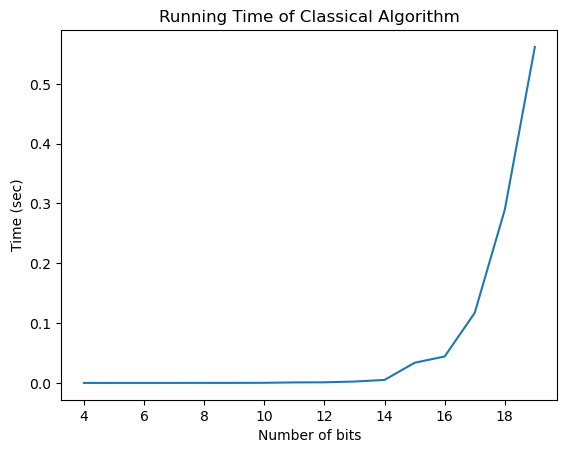

In [15]:
ns = range(4, 20)
times = []
for n in ns:
    start = time.time()
    solve_deutsch_jozsa(n, _f)
    times += [time.time() - start]
plt.plot(ns, times)
plt.xlabel('Number of bits'); plt.ylabel('Time (sec)'); plt.title('Running Time of Classical Algorithm')

### Aside: Probabilistic Solution to Deutsch-Jozsa Problem

1. What if we allowed for some error?
2. Naively, we could just sample random inputs and test if all the outputs are the same.
3. Intuitively, since we are gauranteed either a constant or balanced function, the probability that we have a constant function is high if all the outputs are the same.

In [16]:
import random
def psolve_deutsch_jozsa(nbits: int, f: Callable[list[bool], bool], samples) -> str:
    def randbits(nbits):
        # Generate random bits of length nbits
        return [random.choice([False, True]) for x in range(nbits)]
    # Count
    true_count = 0; false_count = 0
    for b in [randbits(nbits) for i in range(samples)]: 
        if f(b):
            true_count += 1
        else:
            false_count += 1
    if true_count == samples or false_count == samples:
        # If
        return "constant"
    else:
        # We are guaranteed that f is constant or balanced
        return "balanced"
    # no error case

(array([883.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

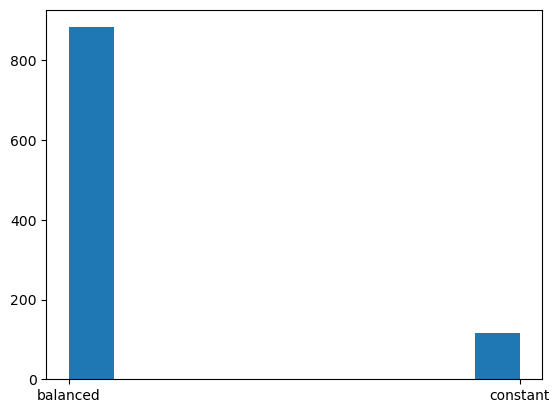

In [17]:
# Testing the performance
acc = []
for i in range(1000):
    acc += [psolve_deutsch_jozsa(3, _f, 4)]
plt.hist(acc)

#### Wow, that worked pretty well!

As a function of samples $K$, what can we say about the probability of error?
1. What's the probability that we say constant given that it's constant?

$$
P(\text{constant} | \text{constant}) = P(\text{all same} | \text{constant}) = 1
$$

2. What's the probability that we say balanced given that it's constant?

$$
P(\text{balanced} | \text{constant}) = P(\text{not all same} | \text{constant}) = 0
$$

3. What's the probability that we say constant given that it's balanced?

$$
P(\text{constant} | \text{balanced}) = P(\text{all same} | \text{balanced}) = (1/2)^{K-1}
$$

4. What's the probability that we say balanced given that it's balanced?

$$
P(\text{balanced} | \text{balanced}) = P(\text{not all same} | \text{balanced}) = 1 - P(\text{all same} | \text{balanced}) = 1 - (1/2)^{K-1}
$$

Perhaps surprisingly, the probability of error is not related to $n$, the length of the bit-string!

In [18]:
print("Probability of error", .5**(4-1))
print("Probability correct", 1 - .5**(4-1))
# Note that the analysis matches our sampling

Probability of error 0.125
Probability correct 0.875


## Quantum Oracles

In the classical setting, we could easily implement $f : \{0, 1\}^n \rightarrow \{0, 1\}$ as either a constant function (i.e., always 0 or 1) or a balanced function. However, there are two constraints in the quantum setting:
1. Assuming that we have a **quantum oracle** $U_f$ that mimics the behavior of $f$, how do we use it in a way that $U_f$ is reversible?
2. The idea of an **oracle** is that we can assume that have access to some blackbox function without worrying about creating one. Nevertheless, we'll show some examples of oracles so that we can show that it's possible to encode classical function as oracle and to test our functions.

### Issue 1: Reading from oracle

1. Reading from an oracle needs to be reversible.
2. This means that the construction of our oracle should look like (in little endian)

$$
U_f |y, x\rangle = |z\rangle
$$

where $x$ is the input, $y$ is some extra qubits, and $z$ has enough information to encode $x$, $y$, and $f(x)$.

### Solution 1: Xor oracle

Assume that the encoding of the input and output to the oracle is

$$
U_f |y, x\rangle = |(y \oplus f(x), x)\rangle
$$

where $\oplus$ is exclusive or.
1. Clearly we can recover $|x\rangle$ since we copy it from the input to the output.
2. If $|y\rangle = |0\rangle$, then
    - $f(x) = 0$ gives us $0$
    - $f(x) = 1$ gives us $1$.
3. When $|y\rangle = |1\rangle$, the answers are flipped.

### Issue 2: Constructing oracles

We'll illustrate for the constant and balanced oracles necessary for Deustch-Josza problem.

#### Example: A constant zero quantum oracle on 2 qubit inputs

1. We are looking for a $U_0$ that satisfies

$$
U_0 |0 , q_1 q_0\rangle = |0 \oplus 0, q_1' q_0' \rangle
$$

for any $|0, q_1 q_0\rangle$.

2. The third qubit (left-most) is where we are putting the output.

3. It is in this sense that we have a constant $0$ function.

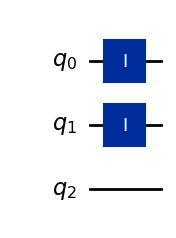

In [19]:
const_oracle0 = QuantumCircuit(3)
const_oracle0.id(0)
const_oracle0.id(1)
# q_0 and q_1 encode inputs
# q_2 encodes output
const_oracle0.draw(output="mpl", style="iqp")

In [20]:
x = one ^ one
U_0 = Operator(const_oracle0)
# Check that qubit 2 (left-most since little endian), is zero
(zero ^ x).evolve(U_0).draw("latex")

<IPython.core.display.Latex object>

#### Example: Another constant zero quantum oracle

Note that there are many potential oracles. Here's another one.

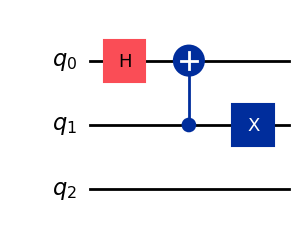

In [21]:
another_const_oracle0 = QuantumCircuit(3)
another_const_oracle0.h(0)
another_const_oracle0.cx(1, 0)
another_const_oracle0.x(1)
# q_0 and q_1 encode inputs
# q_2 encodes output
another_const_oracle0.draw(output="mpl", style="iqp")

In [22]:
x = one ^ zero
U_0_p = Operator(another_const_oracle0)
# Check that qubit 2 (left-most since little endian), is zero
(zero ^ x).evolve(U_0_p).draw("latex")

<IPython.core.display.Latex object>

We can measure and check our answer.

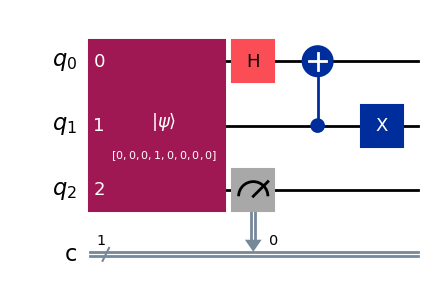

In [23]:
another_const_oracle0 = QuantumCircuit(3, 1)
x = one ^ one
another_const_oracle0.initialize(zero ^ x)
another_const_oracle0.h(0)
another_const_oracle0.cx(1, 0)
another_const_oracle0.x(1)
another_const_oracle0.measure(2, 0)
another_const_oracle0.draw(output="mpl", style="iqp")

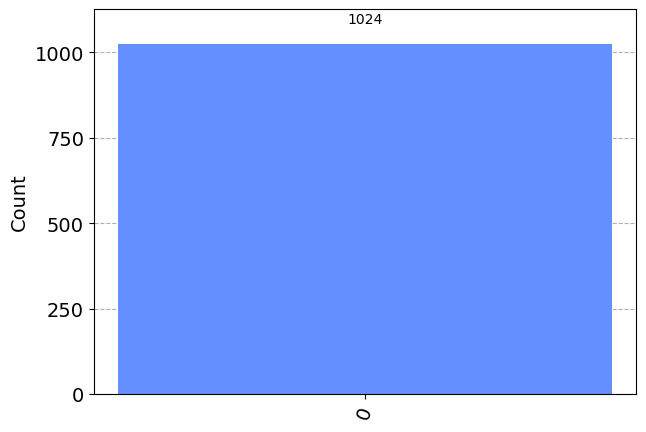

In [24]:
results = sim.run(another_const_oracle0, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

#### Example: A constant one quantum oracle on 2 qubit inputs

1. We are looking for a $U_1$ that satisfies

$$
U_1 |1, q_1 q_0\rangle = |1 \oplus 0, q_1' q_0' \rangle
$$

for any $|0 q_1 q_0\rangle$.

2. The third qubit (left-most) is where we are putting the output which is always $1$.

3. It is in this sense that we have a constant $1$ function.

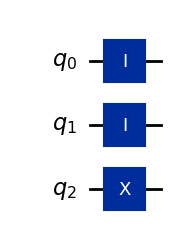

In [25]:
const_oracle1 = QuantumCircuit(3)
const_oracle1.id(0)
const_oracle1.id(1)
const_oracle1.x(2)
# q_0 and q_1 encode inputs
# q_2 encodes output
const_oracle1.draw(output="mpl", style="iqp")

In [26]:
x = one ^ zero
U_1 = Operator(const_oracle1)
# Check that qubit 2 (left-most since little endian), is one
(zero ^ x).evolve(U_1).draw("latex")

<IPython.core.display.Latex object>

#### Example: A balanced quantum oracle

1. We are looking for a $U_b$ that satisfies

$$
U_b |0, q_1 q_0\rangle = |0 \oplus 0, q_1' q_0' \rangle
$$

for half of $|q_1 q_0\rangle$ and

$$
U_b |0, q_1 q_0\rangle = |0 \oplus 1, q_1' q_0' \rangle
$$

for the rest of $|q_1 q_0\rangle$.

2. The third qubit (left-most) is where we are putting the output.

3. It is in this sense that we have a constant $0$ function.

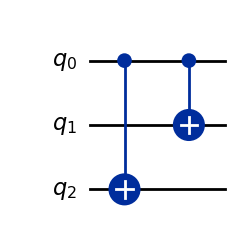

In [27]:
b_oracle = QuantumCircuit(3)
b_oracle.cx(0, 2)
b_oracle.cx(0, 1)
# q_0 and q_1 encode inputs
# q_2 encodes output
b_oracle.draw(output="mpl", style="iqp")

In [28]:
x = one ^ zero
U_b = Operator(b_oracle)

As a check that this is a correct encoding of a balanced oracle, we need to find two inputs that produce 0 and two inputs that produce 1. The two inputs that produce 0 are given below.

In [29]:
# Check the left-most qubit is 0
(zero ^ (zero ^ zero)).evolve(U_b).draw("latex")

<IPython.core.display.Latex object>

In [30]:
# Check the left-most qubit is 0
(zero ^ (one ^ zero)).evolve(U_b).draw("latex")

<IPython.core.display.Latex object>

The two inputs that produce 1 are given next.

In [31]:
(zero ^ (zero ^ one)).evolve(U_b).draw("latex")

<IPython.core.display.Latex object>

In [32]:
(zero ^ (one ^ one)).evolve(U_b).draw("latex")

<IPython.core.display.Latex object>

## Quantum Solution

We've established that the classical deterministic solution is exponential. We've also established that there is an efficient classical probabilistic solution that has constant complexity. We'll now give a quantum algorithm for solving the Deutsch-Jozsa problem. We'll begin with $U_f$ that works on 2-qubit inputs so we'll need 3-qubits to handle the xor oracle. The $n$-qubit case follows as a straightforward generalization. We'll choose the following encoding of the output
- Produce $|00\rangle$ when $U_f$ is constant.
- Produce any other qubit string when $U_f$ is balanced.

At a high-level, this algorithm works by cleverly encoding the answer to the problem in the phase of a quantum state. The idea of cleverly encoding the answer in the phase of a quantum state is used in many quantum algorithms.

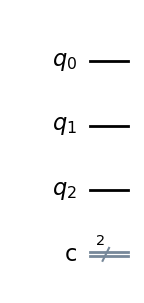

In [33]:
# Construct a circuit that solves deutsch-jozsa on 2 qubits.
dj_circ = QuantumCircuit(3, 2)
dj_circ.draw(output="mpl", style="iqp")

### Step 1: Initial State

Initialize state to $|100\rangle$. Since $q_0$ and $q_1$ are already $|0\rangle$, we just apply the $X$ gate to flip $q_2$ from $|0\rangle$ to $|1\rangle$.

In [34]:
# Step 1: Create initial state
dj_circ.x(2)
dj_circ.barrier(label="Step 1 | Step 2")

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

#### State after step 1

The state after step 1 is

\begin{align*}
|\psi_1\rangle & = |100\rangle \,.
\end{align*}

### Step 2: Put in superposition

Apply $H^{\otimes 3} = \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^3} \sum_{y \in \{0, 1\}^3}(-1)^{x \cdot y} |x\rangle\langle y|$ where $x \cdot y$ is the dot product.

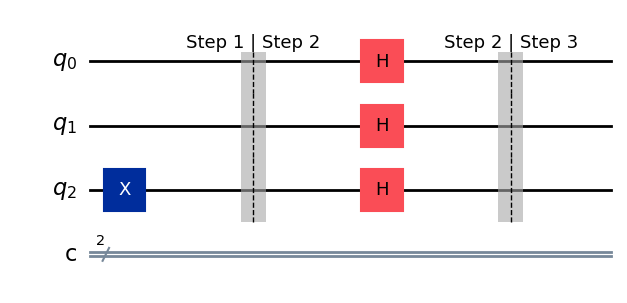

In [35]:
# Step 2: Apply (H ^ H ^ H)
dj_circ.h(0); dj_circ.h(1); dj_circ.h(2)
dj_circ.barrier(label="Step 2 | Step 3")
dj_circ.draw(output="mpl", style="iqp")

#### State after step 2


We define

$$
\{ 0, 1 \}^{3} = \{ 000, \dots 111 \}
$$

so that the summation is over quantum state vectors.

Thus
\begin{align*}
|\psi_2\rangle & = H^{\otimes 3} |\psi_1\rangle \tag{Step 2} \\
& = H^{\otimes 3} |100\rangle \tag{substitute $|\psi_0\rangle$} \\
& = \left( \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^3} \sum_{y \in \{0, 1\}^3}(-1)^{x \cdot y} |x\rangle\langle y| \right) |100\rangle \tag{definition $H^{\otimes n}$ } \\
& = \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^3} \sum_{y \in \{0, 1\}^3}(-1)^{x \cdot y} |x\rangle\langle y||100\rangle \tag{linearity} \\
& = \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^3} (-1)^{x \cdot |100\rangle} |x\rangle \tag{non-zero when $y = |100\rangle$} \\
\end{align*}

### Step 3: Apply oracle

Apply the oracle

$$
U_o |y, x\rangle = |y \oplus f(x), x\rangle \,.
$$

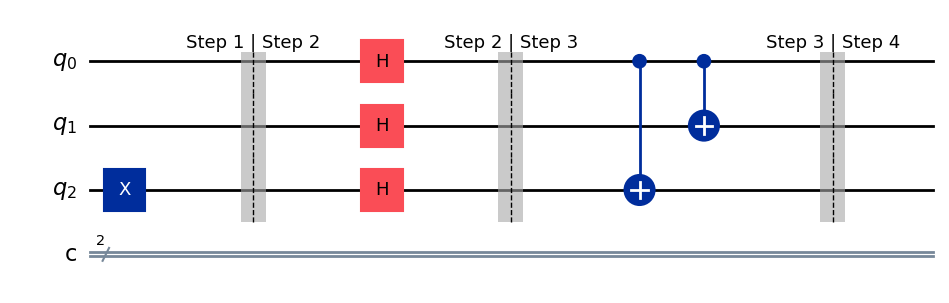

In [36]:
# Step 3: Apply oracle by splicing in the balanced oracle
dj_circ = dj_circ.compose(b_oracle)
dj_circ.barrier(label="Step 3 | Step 4")
dj_circ.draw(output="mpl", style="iqp")

#### State after step 3

After we apply the oracle, we obtain the following quantum state

\begin{align*}
|\psi_3\rangle & = U_o |\psi_2\rangle \\
& = \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^3} (-1)^{x \cdot |100\rangle} U_o |x\rangle \tag{linearity} \\
& = \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^2} \sum_{y \in \{0, 1\}} (-1)^{|y, x\rangle \cdot |100\rangle} U_o |y, x\rangle \tag{rearrange} \\
& = \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^2} \sum_{y \in \{0, 1\}} (-1)^{|y \rangle} |y \oplus f(x), x\rangle \tag{$U_o$} \\
& = \frac{1}{\sqrt{2^3}} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} (|0\rangle - |1\rangle) \rangle|x\rangle \tag{simplification} \\
& = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) \rangle \otimes \left( \frac{1}{\sqrt{2^2}} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} |x\rangle \right) \tag{rearrange} \\
& = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) \rangle \otimes |\psi_3'\rangle \tag{label first half $|\psi_3\rangle$} \,.
\end{align*}

Observe how the result of the oracle $|f(x)\rangle$ has snuck its way into the phase of $\psi_2'\rangle$.

### Step 4: Prepare for measurement

In this next step, we are going to try to extract the phase of $|\psi_3'\rangle$. Towards this end, we will apply $H^{\otimes 2} = \frac{1}{\sqrt{2^2}} \sum_{x \in \{0, 1\}^2} \sum_{y \in \{0, 1\}^2}(-1)^{x \cdot y} |x\rangle\langle y|$ to $|\psi_3'\rangle$ so that it is in a form that we can measure.

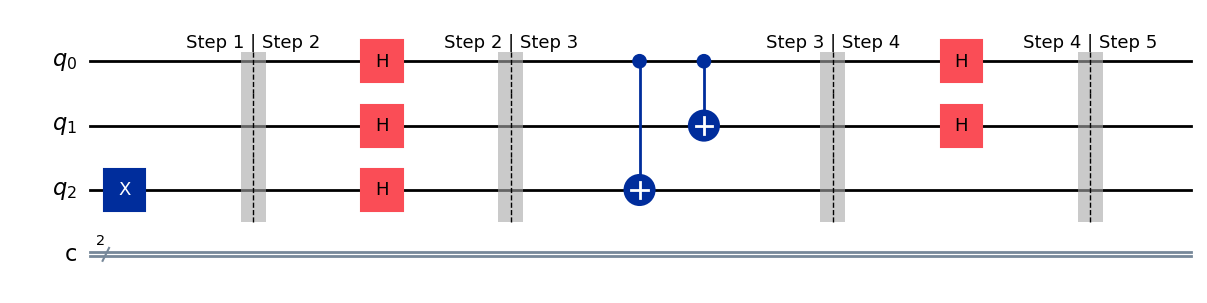

In [37]:
# Step 4: Apply (H ^ H ^ I)
dj_circ.h(0); dj_circ.h(1)
dj_circ.barrier(label="Step 4 | Step 5")
dj_circ.draw(output="mpl", style="iqp")

#### State after step 4

After applying step 4, we obtain the following quantum state

\begin{align*}
|\psi_4'\rangle & = H^{\otimes 2} |\psi_3'\rangle \tag{Step 4} \\
& = \left( \frac{1}{\sqrt{2^2}} \sum_{x \in \{0, 1\}^2} \sum_{y \in \{0, 1\}^2}(-1)^{x \cdot y} |x\rangle\langle y|  \right) \left( \frac{1}{\sqrt{2^2}} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} |x\rangle \right) \tag{definition of $H^{\otimes 2}$ and $|\psi_2'\rangle$} \\
& = \frac{1}{2^2} \sum_{x \in \{0, 1\}^2} \sum_{y \in \{0, 1\}^2} \sum_{z \in \{0, 1\}^2} (-1)^{x \cdot y} (-1)^{|f(z)\rangle} |x\rangle\langle y||z\rangle \tag{linearity} \\
& = \frac{1}{2^2} \sum_{x \in \{0, 1\}^2} \sum_{y \in \{0, 1\}^2} (-1)^{x \cdot y} (-1)^{|f(y)\rangle} |y\rangle 
\tag{non-zero when $y = z$} \\
& = \frac{1}{2^2} \sum_{y \in \{0, 1\}^2} \sum_{x \in \{0, 1\}^2} (-1)^{x \cdot y} (-1)^{|f(y)\rangle} |y\rangle \tag{rearrange sum} \\
& = \frac{1}{2^2} \sum_{y \in \{0, 1\}^2} (-1)^{|f(y)\rangle} \sum_{x \in \{0, 1\}^2} (-1)^{x \cdot y} |y\rangle 
\tag{factor} \\
& = \frac{1}{2^2} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} \sum_{y \in \{0, 1\}^2} (-1)^{x \cdot y} |x\rangle \tag{rename x for y and symmetry of $\cdot$} \\
& = \frac{1}{2^2} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} |00\rangle + \frac{1}{2^2} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} (-1)^{|01\rangle \cdot x} |01\rangle \\
& \phantom{=} + \frac{1}{2^2} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} (-1)^{|10\rangle \cdot x} |10\rangle + \frac{1}{2^2} \sum_{x \in \{0, 1\}^2} (-1)^{|f(x)\rangle} (-1)^{|11\rangle \cdot x} |11\rangle \tag{expand} \,.
\end{align*}

##### Step 5: Measure

Measure $|\psi_4'\rangle$.

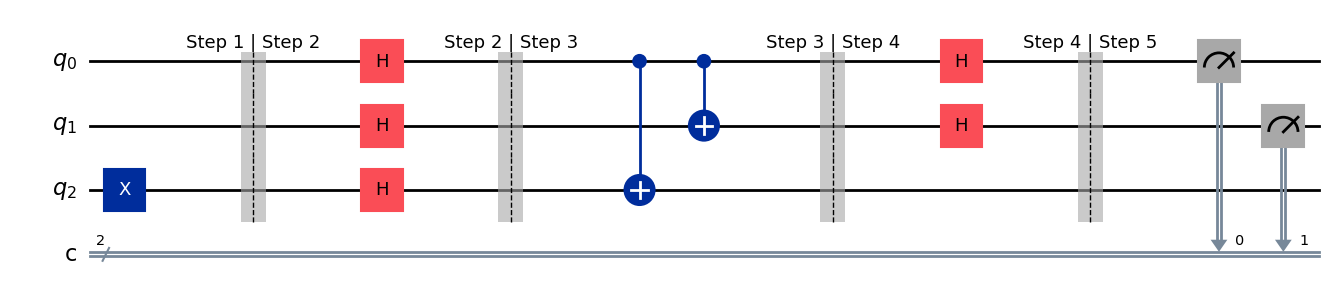

In [38]:
# Step 5: Measure
dj_circ.measure(0, 0)
dj_circ.measure(1, 1)
dj_circ.draw(output="mpl", style="iqp")

#### State after step 5

The amplitude of state $|00\rangle$ is

$$
\frac{1}{2^n} \sum_{x \in \{ 0, 1\}} (-1)^{f(x)}
$$

which is 
1. $1$ if $f(x) = 0$ always,
2. $-1$ if $f(x) = -1$ always,
3. $0$ when $f(x)$ is balanced.

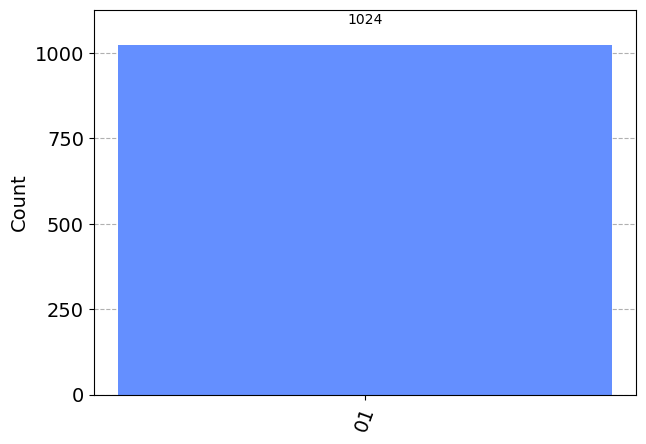

In [39]:
results = sim.run(dj_circ, shots=1024).result()
answer = results.get_counts()
# Should expect |01>
plot_histogram(answer)

### Putting it Together

We gather the circuit from before into a single function and generalize it to work with n qubits.

In [40]:
def gen_dj_circ(oracle_circ):
    # Create circuit
    n = oracle_circ.num_qubits
    dj_circ = QuantumCircuit(n, n-1)

    # Hadamard inputs
    for i in range(n - 1):
        dj_circ.h(i)
    dj_circ.barrier(label="Step 1 | Step 2")
        
    # Set oracle output
    dj_circ.x(n-1); dj_circ.h(n-1)
    dj_circ.barrier(label="Step 2 | Step 3")
        
    # Splice in the oracle
    dj_circ = dj_circ.compose(oracle_circ)
    dj_circ.barrier(label="Step 3 | Step 4")
        
    # Hadmard outputs
    for i in range(n - 1):
        dj_circ.h(i)
    dj_circ.barrier(label="Step 4 | Step 5")
        
    # Measure
    for i in range(n - 1):
        dj_circ.measure(i, i)
        
    return dj_circ

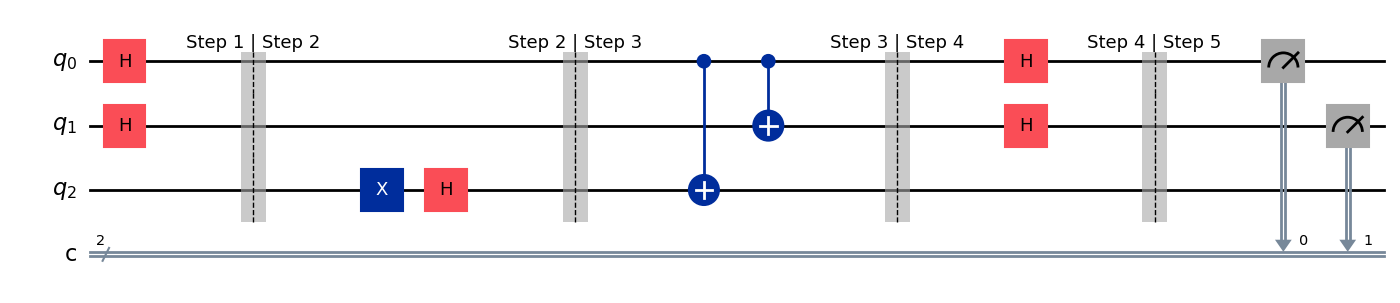

In [41]:
gen_dj_circ(b_oracle).draw(output="mpl", style="iqp")

#### Example

Here's an example with the constant oracle.

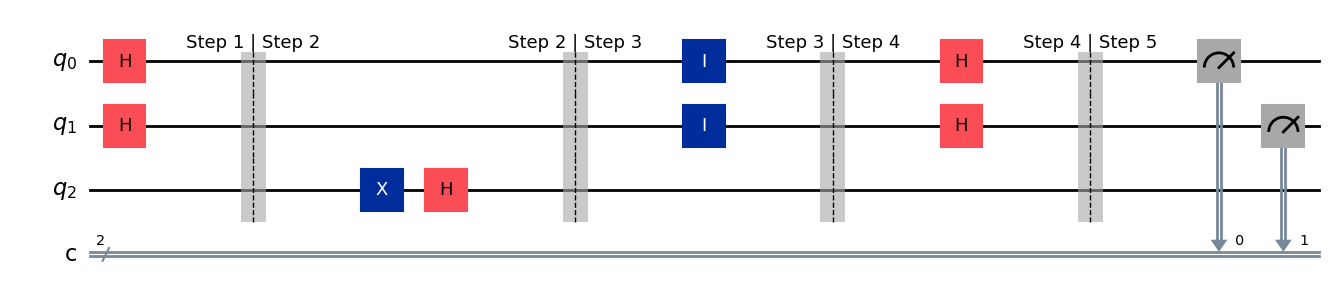

In [42]:
dj_circ_c = gen_dj_circ(const_oracle0)
dj_circ_c.draw(output="mpl", style="iqp")

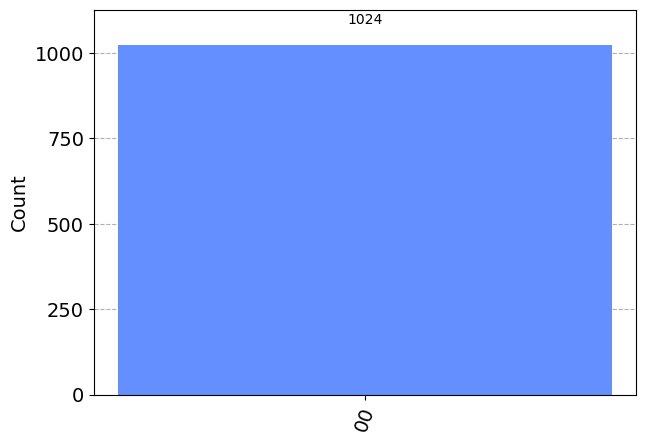

In [43]:
results = sim.run(dj_circ_c, shots=1024).result()
answer = results.get_counts()
# Should expect all |00>
plot_histogram(answer)

### Comparing Algorithms


1. Classical algorithm has $O(2^n)$ runtime and no error.
2. Probabilisitic algorithm has $O(k$ runtime where $k$ is the number of samples and probability $2^{k-1}$ of predicting constant when balanced.
3. Quantum algorithm has $O(1)$ runtime with no error.

## Summary

1. We introduced the Deutsch-Jozsa problem.
2. Gave classical and classical probabilistic algorithms.
3. Gave a quantum solution to Deutsh-Jozsa problem. We also introduced the notion of a quantum oracle.